In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import re
import datetime
import dateutil.parser
import statistics 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree, metrics


In [2]:
df = pd.read_csv('Indian Earthquakes List Update_Magnitudes (1).csv',header=8, encoding = "ISO-8859-1", parse_dates=True)

/home/varun/LE-Course/Sem2/SMAI/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,1,2,3,6,7,9,10,11,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.columns = ( df.iloc[0].fillna('') + df.iloc[1].fillna(''))
df.columns = np.vectorize(lambda x: x.strip())(df.columns)

In [4]:
df = df.drop([0,1])
df = df.reset_index(drop=True)

In [5]:
df

,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME(UTC),(IST),MAGNITUDEMw,Mw,Mb,Mb,Ms,ML,LAT (N),LONG (E),DEPTH (km),INTENSITYMM,MMI,MME,LOCATION,REFERENCE
0,1,-2474,0,0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0,NaN,NaN,NaN,NaN,Dr STGR
1,2,-325,0,0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0,NaN,NaN,NaN,NaN,Dr STGR
2,3,25,0,0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,72.9,33.72,0,NaN,NaN,NaN,NaN,Dr STGR
3,4,26,5,10,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,5.698851894,5.999685205,17.3,80.1,NaN,NaN,NaN,NaN,NaN,NEIC
4,5,26,5,10,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,6.075520196,5.999685205,26,97,80,NaN,NaN,NaN,Myanmar,G-R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,52970,2019,7,28,19:24:08,00:54:08/2019-07-29/,3.2,3.2,NaN,3.07428,2.32377,2.91501,32.8°N,78.4°E,10,NaN,NaN,NaN,Jammu & Kashmir,NaN
52985,52971,2019,7,28,10:44:10,16:14:10,3.6,3.6,NaN,3.43659,2.78301,3.33473,25.5°N,90.4°E,70,NaN,NaN,NaN,"Distt. East Garo Hills ,Meghalaya",NaN
52986,52972,2019,7,28,21:25:06,7/29/2019 2:55,4,4,NaN,3.79891,3.24225,3.75446,23.2°N,86.5°E,22,NaN,NaN,NaN,"Distt. Puruliya, West Bengal",NaN
52987,52973,2019,7,29,3:33:53,9:03:53,4.3,4.3,NaN,4.07065,3.58668,4.06925,32.8°N,76.4°E,20,NaN,NaN,NaN,"Distt. Lahaul-Spiti,Himachal Pradesh",NaN


In [6]:
def ints(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return int(x)
        else:
            return -1
    return -1

In [7]:
def floats(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return float(x)
        else:
            return -1
    return -1

In [8]:
for col in ['YEAR','DATE','MONTH']:
#     df[col] = df[col].dropna()
    df[col] = df[col].apply(ints)

In [9]:
for col in ['Mw','MAGNITUDEMw']:
#     df[col] = df[col].dropna()
    df[col] = df[col].apply(floats)

In [10]:
df = df.drop(np.where((df['YEAR']<=0)|(df['MONTH']<=0) | (df['DATE']<=0))[0])

In [11]:
df = df.drop(df.index[df['Mw']<=0])

In [12]:
np.where(df['ORIGIN TIME(UTC)'].isna() & df['(IST)'].notna())

(array([], dtype=int64),)

In [13]:
np.where(df['ORIGIN TIME(UTC)'].notna() & df['(IST)'].isna())

(array([   15,    18,    22, ..., 19731, 19732, 19733]),)

In [14]:
np.where(df['MAGNITUDEMw'].notna() & df['Mw'].isna())

(array([], dtype=int64),)

In [15]:
np.where(df['MAGNITUDEMw'].isna() & df['Mw'].notna())

(array([], dtype=int64),)

In [16]:
def formatint(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return int(x)
        else:
#             print(x)
            return pd.NA
    return x

In [17]:
def formatfloat(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return float(x)
        else:
#             print(x)
            return pd.NA
    return x

In [18]:
df['MAGNITUDEMw'] = df['MAGNITUDEMw'].apply(formatfloat)

In [19]:
df

,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME(UTC),(IST),MAGNITUDEMw,Mw,Mb,Mb,Ms,ML,LAT (N),LONG (E),DEPTH (km),INTENSITYMM,MMI,MME,LOCATION,REFERENCE
332,318,1852,3,31,NaN,NaN,6.0,6.0,5.610507246,5.610507246,5.538461538,5.853095488,26.17,85.9,NaN,NaN,NaN,NaN,NaN,NEIC
449,435,1863,11,18,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,26.47,84.43,NaN,NaN,NaN,NaN,NaN,NEIC
572,558,1871,1,31,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,16.98,82.33,NaN,NaN,NaN,NaN,NaN,NEIC
590,576,1872,4,14,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,26.3,89.53,NaN,NaN,NaN,NaN,NaN,NEIC
645,631,1882,6,28,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,22.6,93.4,NaN,NaN,NaN,NaN,NaN,NEIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,52970,2019,7,28,19:24:08,00:54:08/2019-07-29/,3.2,3.2,NaN,3.07428,2.32377,2.91501,32.8°N,78.4°E,10,NaN,NaN,NaN,Jammu & Kashmir,NaN
52985,52971,2019,7,28,10:44:10,16:14:10,3.6,3.6,NaN,3.43659,2.78301,3.33473,25.5°N,90.4°E,70,NaN,NaN,NaN,"Distt. East Garo Hills ,Meghalaya",NaN
52986,52972,2019,7,28,21:25:06,7/29/2019 2:55,4.0,4.0,NaN,3.79891,3.24225,3.75446,23.2°N,86.5°E,22,NaN,NaN,NaN,"Distt. Puruliya, West Bengal",NaN
52987,52973,2019,7,29,3:33:53,9:03:53,4.3,4.3,NaN,4.07065,3.58668,4.06925,32.8°N,76.4°E,20,NaN,NaN,NaN,"Distt. Lahaul-Spiti,Himachal Pradesh",NaN


In [20]:
df = df[['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'Mw', 'LAT (N)', 'LONG (E)',
       'DEPTH (km)', 'REFERENCE']]

In [21]:
df.head()

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE
332,1852,3,31,NaN,6.0,26.17,85.9,NaN,NEIC
449,1863,11,18,NaN,5.0,26.47,84.43,NaN,NEIC
572,1871,1,31,NaN,5.0,16.98,82.33,NaN,NEIC
590,1872,4,14,NaN,5.0,26.3,89.53,NaN,NEIC
645,1882,6,28,NaN,5.0,22.6,93.4,NaN,NEIC


In [22]:
df['ORIGIN TIME(UTC)'].fillna('00:00:00',inplace=True)
df['DEPTH (km)'].fillna(0,inplace=True)
df['REFERENCE'].fillna('',inplace=True)

/home/varun/LE-Course/Sem2/SMAI/env/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [23]:
df['ORIGIN TIME(UTC)']!=0

332      True
449      True
572      True
590      True
645      True
         ... 
52984    True
52985    True
52986    True
52987    True
52988    True
Name: ORIGIN TIME(UTC), Length: 20160, dtype: bool

In [24]:
def time2str(x):
    if type(x) in [int,float]:
        x = x/1000.0
        return datetime.datetime.fromtimestamp(s).strftime('%H:%M:%S.%f')
    x = x.replace(' ',':')
    x = x.replace('.',':')
    flag = (x.find('PM') > -1)
    x = re.sub('[^0-9.:]*', '', x)
    
    x = np.array([ int(t) if t.isdigit() else -1 for t in x.split(':')])
    x = x[x>=0]
    
    x_ = np.zeros(4)
    try:
        x_[:x.shape[0]] = x
    except:
        print(x)
    
    if flag:
        x_[0] = x_[0] + (12 if x_[0]<12 else 0)
    x_ = np.min(np.vstack([x_,np.array([23,59,59,99])]),axis = 0)
    return '{}:{}:{}.{}'.format(int(x_[0]),int(x_[1]),int(x_[2]),int(x_[3]))
#     return np.sum(x_ * np.array([3600,60,1,0.01]))

In [25]:
def cols2timestamp(row):
    year=row['YEAR']
    month=row['MONTH']
    day=row['DATE']
    time = '' if pd.isnull(row['ORIGIN TIME(UTC)']) else time2str(row['ORIGIN TIME(UTC)'])
    try:
        x = dateutil.parser.parse('{}-{}-{} {}'.format(year,month,day,time))
    except:
        x = dateutil.parser.parse('{}-{}-{} {}'.format(year,month,day-3,time))
    return x
    

In [26]:
df['TIMESTAMP'] = df.apply(cols2timestamp,axis = 1)

<ipython-input-26-052cde2ff581>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIMESTAMP'] = df.apply(cols2timestamp,axis = 1)


In [27]:
df['ORIGIN TIME(UTC)'] = df['ORIGIN TIME(UTC)'].apply(lambda x:datetime.datetime.timestamp(dateutil.parser.parse(time2str(x))))

<ipython-input-27-414c838f121b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ORIGIN TIME(UTC)'] = df['ORIGIN TIME(UTC)'].apply(lambda x:datetime.datetime.timestamp(dateutil.parser.parse(time2str(x))))


In [28]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP
332,1852,3,31,1.599417e+09,6.0,26.17,85.9,0,NEIC,1852-03-31 00:00:00
449,1863,11,18,1.599417e+09,5.0,26.47,84.43,0,NEIC,1863-11-18 00:00:00
572,1871,1,31,1.599417e+09,5.0,16.98,82.33,0,NEIC,1871-01-31 00:00:00
590,1872,4,14,1.599417e+09,5.0,26.3,89.53,0,NEIC,1872-04-14 00:00:00
645,1882,6,28,1.599417e+09,5.0,22.6,93.4,0,NEIC,1882-06-28 00:00:00
...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599487e+09,3.2,32.8°N,78.4°E,10,,2019-07-28 19:24:08
52985,2019,7,28,1.599456e+09,3.6,25.5°N,90.4°E,70,,2019-07-28 10:44:10
52986,2019,7,28,1.599494e+09,4.0,23.2°N,86.5°E,22,,2019-07-28 21:25:06
52987,2019,7,29,1.599430e+09,4.3,32.8°N,76.4°E,20,,2019-07-29 03:33:53


In [29]:
def NS(x):
    if type(x) in [int,float]:
        return x
    
    flag = x.find('S')>-1
    x = re.sub('[^0-9.]', '', x)
    return float(x) * (-1 if flag else 1)

In [30]:
def EW(x):
    if type(x) in [int,float]:
        return x
    
    flag = x.find('W')>-1
    x = re.sub('[^0-9.]', '', x)
    return float(x) * (-1 if flag else 1)

In [31]:
df['LAT (N)'] = df['LAT (N)'].apply(NS)
df['LONG (E)'] = df['LONG (E)'].apply(EW)

<ipython-input-31-139af6abc6bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAT (N)'] = df['LAT (N)'].apply(NS)
<ipython-input-31-139af6abc6bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LONG (E)'] = df['LONG (E)'].apply(EW)


In [32]:
df['DEPTH (km)'] = df['DEPTH (km)'].apply(lambda x: float(x))

<ipython-input-32-ce4b14652dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEPTH (km)'] = df['DEPTH (km)'].apply(lambda x: float(x))


In [33]:
df['Mw'].mean()

4.532753042955854

In [34]:
df['Mw'].median()

4.4

In [35]:
df['label'] = df['Mw'] > df['Mw'].mean()

<ipython-input-35-a921f4df2ce1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Mw'] > df['Mw'].mean()


In [36]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP,label
332,1852,3,31,1.599417e+09,6.0,26.17,85.90,0.0,NEIC,1852-03-31 00:00:00,True
449,1863,11,18,1.599417e+09,5.0,26.47,84.43,0.0,NEIC,1863-11-18 00:00:00,True
572,1871,1,31,1.599417e+09,5.0,16.98,82.33,0.0,NEIC,1871-01-31 00:00:00,True
590,1872,4,14,1.599417e+09,5.0,26.30,89.53,0.0,NEIC,1872-04-14 00:00:00,True
645,1882,6,28,1.599417e+09,5.0,22.60,93.40,0.0,NEIC,1882-06-28 00:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599487e+09,3.2,32.80,78.40,10.0,,2019-07-28 19:24:08,False
52985,2019,7,28,1.599456e+09,3.6,25.50,90.40,70.0,,2019-07-28 10:44:10,False
52986,2019,7,28,1.599494e+09,4.0,23.20,86.50,22.0,,2019-07-28 21:25:06,False
52987,2019,7,29,1.599430e+09,4.3,32.80,76.40,20.0,,2019-07-29 03:33:53,False


In [37]:
def total_in1deg_count(x):
    return df[(df['ORIGIN TIME(UTC)'] < x['ORIGIN TIME(UTC)']) & ((df['LAT (N)']>=x['LAT (N)'] -1) & (df['LAT (N)']<=x['LAT (N)'] + 1)) & ((df['LONG (E)']>=x['LONG (E)'] -1) & (df['LONG (E)']<=x['LONG (E)'] + 1))].shape[0]

In [38]:
def divtd(td1, td2):
    us1 = td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)
    us2 = td2.microseconds + 1000000 * (td2.seconds + 86400 * td2.days)
    return us1 / max(us2,0.0001) # this does integer division, use float(us1) / us2 for fp division

In [39]:
def td2int(td1):
    if td1 ==np.inf:
        return 2**31 - 1
    elif type(td1) in [int,float]:
        return td1
    return td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)

In [40]:
type(2**2047-1)

int

In [41]:
# Add target column
# Add Last Earthquake at (X±0.5,Y±0.5)
# Add Number of Eathquake Before Last date
# Add Median Frequency at (X±0.5,Y±0.5)
pbar = tqdm(total = df.shape[0])

latRange=0.5
longRange=0.5
lastEq=[]
medianFrequency=[]
numEq=[]
timeleft_ratio = []
for index,row in df.iterrows():
#     clear_output(wait=True)
#     print(index,row)
    lat=row['LAT (N)']
    long=row['LONG (E)']
    timeList=df['TIMESTAMP'][((df['LAT (N)']>=lat-latRange)&(df['LAT (N)']<=lat+latRange) )&((df['LONG (E)']<=long+longRange)&(df['LONG (E)']>=long-longRange))]
    
    lastTimes = timeList[timeList<row['TIMESTAMP']]
    if lastTimes.shape[0]==0:
        lastEq.append(dateutil.parser.parse('1700-01-01'))
    else:
        lastEq.append(timeList[timeList<row['TIMESTAMP']].max())
#     np.max(timeList[timeList<row['TIMESTAMP']].max(),dateutil.parser.parse('1800-01-01'))
    numEq.append(timeList.shape[0])

    timeList=timeList.tolist()
    timeList.sort()


    mf_append = 2**63-1
    if len(timeList)>1:
        deqt=[] # Difference 
        for i in range(1,len(timeList)):
            deqt.append(timeList[i]-timeList[i-1])
        mf_append = statistics.median(deqt)
    medianFrequency.append(mf_append)
#     print(divtd((row['TIMESTAMP'] - lastEq[-1]),mf_append))
    if mf_append == 2**63-1:
        mf_append = datetime.timedelta(days=9999999, hours=23, minutes=59, seconds=59, microseconds=999999)
    timeleft_ratio.append(divtd((row['TIMESTAMP'] - lastEq[-1]),mf_append))
    pbar.update(1)

In [42]:
df['Last Eq'] = lastEq
# df['Frequency'] = pd.Series(medianFrequency).to_timestamp()
df['Frequency(Years)'] = medianFrequency
# df['Frequency(Years)'] = df['Frequency(Years)'].Year
df['numEq']=numEq
df['timeRatio'] = timeleft_ratio
# df = df.assign('Frequency'=pd.Series(medianFrequency))

<ipython-input-42-8b2969b00ce5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Eq'] = lastEq
<ipython-input-42-8b2969b00ce5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequency(Years)'] = medianFrequency
<ipython-input-42-8b2969b00ce5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [43]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP,label,Last Eq,Frequency(Years),numEq,timeRatio
332,1852,3,31,1.599417e+09,6.0,26.17,85.90,0.0,NEIC,1852-03-31 00:00:00,True,1700-01-01 00:00:00,58727 days 17:35:49,2,0.946844
449,1863,11,18,1.599417e+09,5.0,26.47,84.43,0.0,NEIC,1863-11-18 00:00:00,True,1700-01-01 00:00:00,9223372036854775807,1,0.005986
572,1871,1,31,1.599417e+09,5.0,16.98,82.33,0.0,NEIC,1871-01-31 00:00:00,True,1700-01-01 00:00:00,9223372036854775807,1,0.006249
590,1872,4,14,1.599417e+09,5.0,26.30,89.53,0.0,NEIC,1872-04-14 00:00:00,True,1700-01-01 00:00:00,159 days 14:28:19,20,394.259512
645,1882,6,28,1.599417e+09,5.0,22.60,93.40,0.0,NEIC,1882-06-28 00:00:00,True,1700-01-01 00:00:00,56 days 02:09:42.450000,27,1188.302929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599487e+09,3.2,32.80,78.40,10.0,,2019-07-28 19:24:08,False,2019-07-08 12:04:08,196 days 16:12:30.800000,9,0.103244
52985,2019,7,28,1.599456e+09,3.6,25.50,90.40,70.0,,2019-07-28 10:44:10,False,2019-03-21 14:30:54,77 days 00:18:07,33,1.673006
52986,2019,7,28,1.599494e+09,4.0,23.20,86.50,22.0,,2019-07-28 21:25:06,False,2019-05-26 05:09:15,500 days 09:51:37,6,0.127251
52987,2019,7,29,1.599430e+09,4.3,32.80,76.40,20.0,,2019-07-29 03:33:53,False,2019-07-24 19:17:12,30 days 05:27:44,87,0.143740


In [44]:
df['TIMESTAMP'] = df['TIMESTAMP'].apply(lambda x: datetime.datetime.timestamp(x))

<ipython-input-44-ba627974ea73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIMESTAMP'] = df['TIMESTAMP'].apply(lambda x: datetime.datetime.timestamp(x))


In [45]:
df['Last Eq'] = df['Last Eq'].apply(lambda x: datetime.datetime.timestamp(x))

<ipython-input-45-3706c90f558b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Eq'] = df['Last Eq'].apply(lambda x: datetime.datetime.timestamp(x))


In [46]:
df['Frequency(Years)'] = df['Frequency(Years)'].apply(td2int)

<ipython-input-46-eec34b770f3c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequency(Years)'] = df['Frequency(Years)'].apply(td2int)


In [47]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP,label,Last Eq,Frequency(Years),numEq,timeRatio
332,1852,3,31,1.599417e+09,6.0,26.17,85.90,0.0,NEIC,-3.715999e+09,True,-8.520357e+09,5074076149000000,2,0.946844
449,1863,11,18,1.599417e+09,5.0,26.47,84.43,0.0,NEIC,-3.348885e+09,True,-8.520357e+09,9223372036854775807,1,0.005986
572,1871,1,31,1.599417e+09,5.0,16.98,82.33,0.0,NEIC,-3.121565e+09,True,-8.520357e+09,9223372036854775807,1,0.006249
590,1872,4,14,1.599417e+09,5.0,26.30,89.53,0.0,NEIC,-3.083635e+09,True,-8.520357e+09,13789699000000,20,394.259512
645,1882,6,28,1.599417e+09,5.0,22.60,93.40,0.0,NEIC,-2.761622e+09,True,-8.520357e+09,4846182450000,27,1188.302929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599487e+09,3.2,32.80,78.40,10.0,,1.564322e+09,False,1.562568e+09,16992750800000,9,0.103244
52985,2019,7,28,1.599456e+09,3.6,25.50,90.40,70.0,,1.564291e+09,False,1.553159e+09,6653887000000,33,1.673006
52986,2019,7,28,1.599494e+09,4.0,23.20,86.50,22.0,,1.564329e+09,False,1.558828e+09,43235497000000,6,0.127251
52987,2019,7,29,1.599430e+09,4.3,32.80,76.40,20.0,,1.564351e+09,False,1.563976e+09,2611664000000,87,0.143740


In [48]:
df.columns

Index(['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'Mw', 'LAT (N)',
       'LONG (E)', 'DEPTH (km)', 'REFERENCE', 'TIMESTAMP', 'label', 'Last Eq',
       'Frequency(Years)', 'numEq', 'timeRatio'],
      dtype='object')

In [49]:
y = df['label']
X = df.drop(['label','Mw'],axis = 1)

In [50]:
[col for col in X.columns if X[col].isnull().any()]

[]

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [52]:
def get_preds_regressor(X_train, X_valid, y_train, y_valid, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return preds

def get_preds_classifier(X_train, X_valid, y_train, y_valid, n_estimators=100):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return preds

In [53]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_cols

['REFERENCE']

In [54]:
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('REFERENCE', 11)]

In [55]:
OHencode = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_X_train = pd.DataFrame(OHencode.fit_transform(X_train[object_cols]))
OH_cols_X_valid = pd.DataFrame(OHencode.transform(X_valid[object_cols]))

OH_cols_X_train.index = X_train.index
OH_cols_X_valid.index = X_valid.index

OH_X_train = X_train.copy()
OH_X_valid = X_valid.copy()

OH_X_train = OH_X_train.drop(object_cols,axis = 1)
OH_X_valid = OH_X_valid.drop(object_cols,axis = 1)

OH_X_train = pd.concat([OH_X_train, OH_cols_X_train],axis = 1) # Your code here
OH_X_valid = pd.concat([OH_X_valid, OH_cols_X_valid], axis = 1) # Your code here

In [56]:
OH_X_train.columns

Index([            'YEAR',            'MONTH',             'DATE',
       'ORIGIN TIME(UTC)',          'LAT (N)',         'LONG (E)',
             'DEPTH (km)',        'TIMESTAMP',          'Last Eq',
       'Frequency(Years)',            'numEq',        'timeRatio',
                        0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10],
      dtype='object')

In [61]:
def get_accuracy_decision(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return accuracy_score(val_y, preds_val),f1_score(val_y, preds_val)

In [62]:
def get_probs_decision(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
    model.fit(train_X, train_y)
    probs = model.predict_proba(val_X)
    return probs

In [63]:
candidate_max_leaf_nodes = list(range(2,25))+ [25, 50] +  list(range(70,200)) + [ 250, 500]
accs = np.ones(len(candidate_max_leaf_nodes)) * np.inf
f1s = np.ones(len(candidate_max_leaf_nodes)) * np.inf
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for idx, lnodes in enumerate(candidate_max_leaf_nodes):
    accs[idx],f1s[idx] = get_accuracy_decision(lnodes, OH_X_train, OH_X_valid, y_train, y_valid)
print(accs)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = candidate_max_leaf_nodes[int(np.argmax(accs))]

[0.65451389 0.66765873 0.66617063 0.69196429 0.70089286 0.71602183
 0.71527778 0.71527778 0.71527778 0.71527778 0.72098214 0.7249504
 0.72767857 0.72842262 0.72842262 0.72842262 0.72842262 0.72842262
 0.72991071 0.72991071 0.73115079 0.73115079 0.73115079 0.73115079
 0.73263889 0.73313492 0.73313492 0.73313492 0.73313492 0.73387897
 0.73363095 0.73363095 0.73313492 0.73363095 0.73487103 0.73487103
 0.73487103 0.73487103 0.73487103 0.73487103 0.73487103 0.73536706
 0.73536706 0.73784722 0.7390873  0.73958333 0.7390873  0.74007937
 0.73958333 0.73933532 0.73883929 0.73883929 0.73859127 0.73883929
 0.73883929 0.73859127 0.73883929 0.73859127 0.73859127 0.73809524
 0.73784722 0.73809524 0.73958333 0.73958333 0.73710317 0.73561508
 0.73338294 0.73412698 0.734375   0.734375   0.73387897 0.73313492
 0.73313492 0.73338294 0.73412698 0.73263889 0.73363095 0.7328869
 0.7328869  0.73313492 0.73263889 0.73263889 0.7328869  0.73263889
 0.73189484 0.73214286 0.73239087 0.73214286 0.73189484 0.732390

Text(0, 0.5, 'Accuracy')

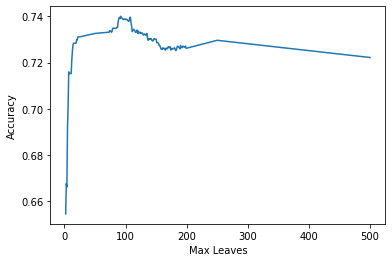

In [64]:
plt.plot(candidate_max_leaf_nodes,accs)
plt.xlabel('Max Leaves')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1')

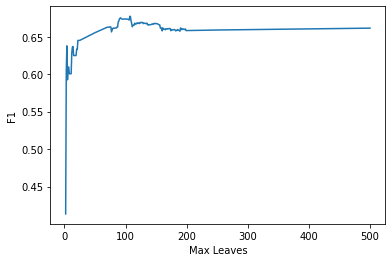

In [65]:
plt.plot(candidate_max_leaf_nodes,f1s)
plt.xlabel('Max Leaves')
plt.ylabel('F1')

In [66]:
best_tree_size

92

In [67]:
candidate_max_leaf_nodes[int(np.argmax(f1s))]

107

In [68]:
accs[107]

0.7286706349206349

In [69]:
num_leaves = 92
get_accuracy_decision(best_tree_size, OH_X_train, OH_X_valid, y_train, y_valid)

(0.7398313492063492, 0.6749302757979546)

In [70]:
model = DecisionTreeClassifier(max_leaf_nodes=92)
model.fit(OH_X_train, y_train)
preds_val = model.predict(OH_X_valid)
accuracy_score(y_valid, preds_val)

0.7398313492063492

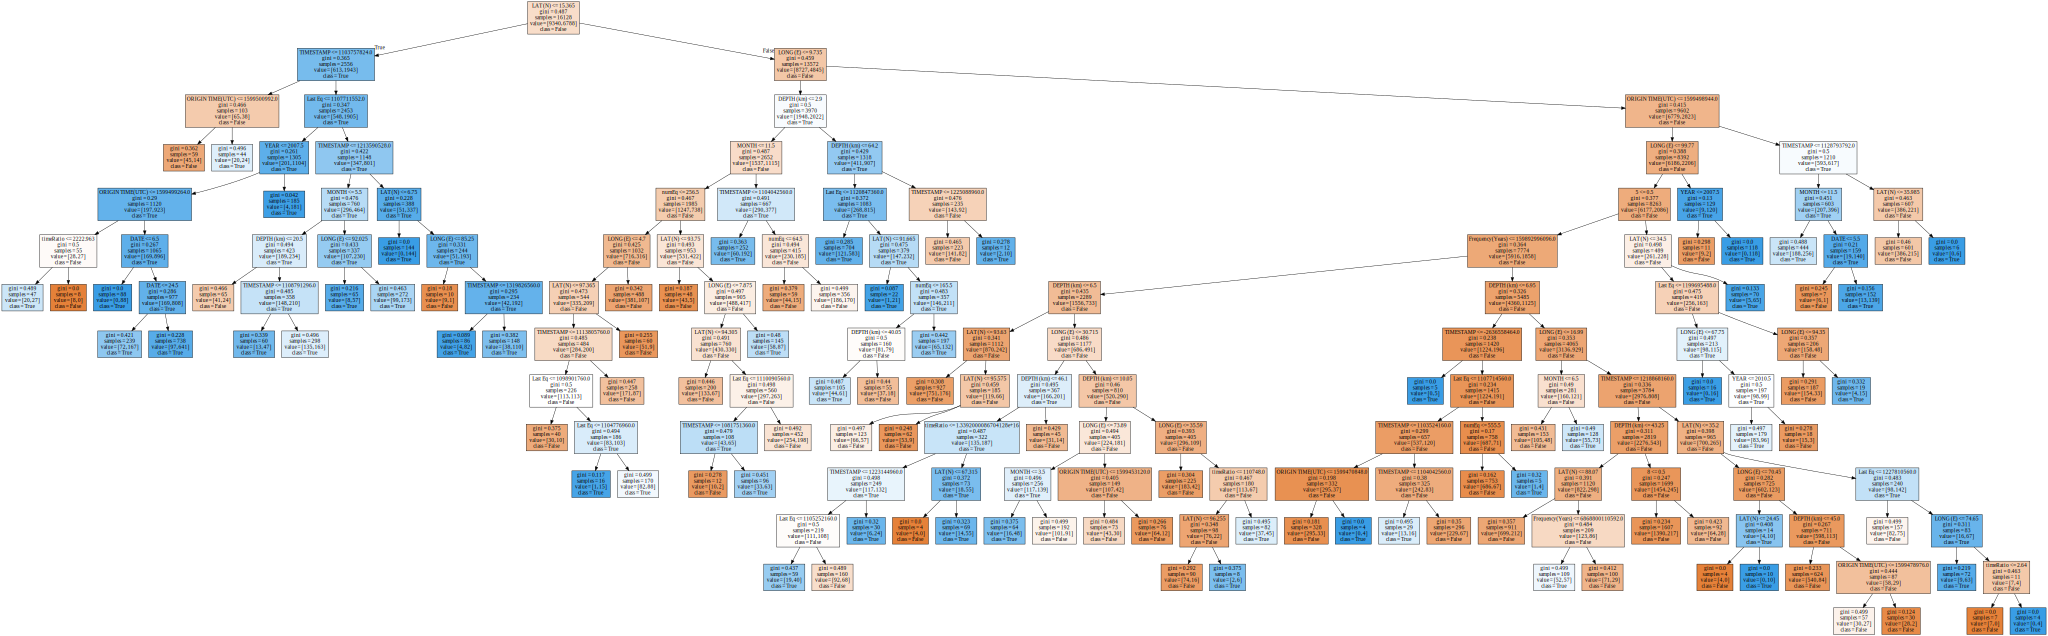

In [71]:
dot_data = tree.export_graphviz(model,filled=True,feature_names=OH_X_train.columns,class_names=['False','True'])
graph = graphviz.Source(dot_data,format='png')
graph

In [72]:
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

In [73]:
probs = model.predict_proba(OH_X_valid)

In [74]:
probs

array([[0.45302013, 0.54697987],
       [0.91102258, 0.08897742],
       [0.52229299, 0.47770701],
       ...,
       [0.86496577, 0.13503423],
       [0.82352941, 0.17647059],
       [0.52247191, 0.47752809]])

In [75]:
preds

array([ True, False, False, ..., False, False, False])

In [76]:
fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

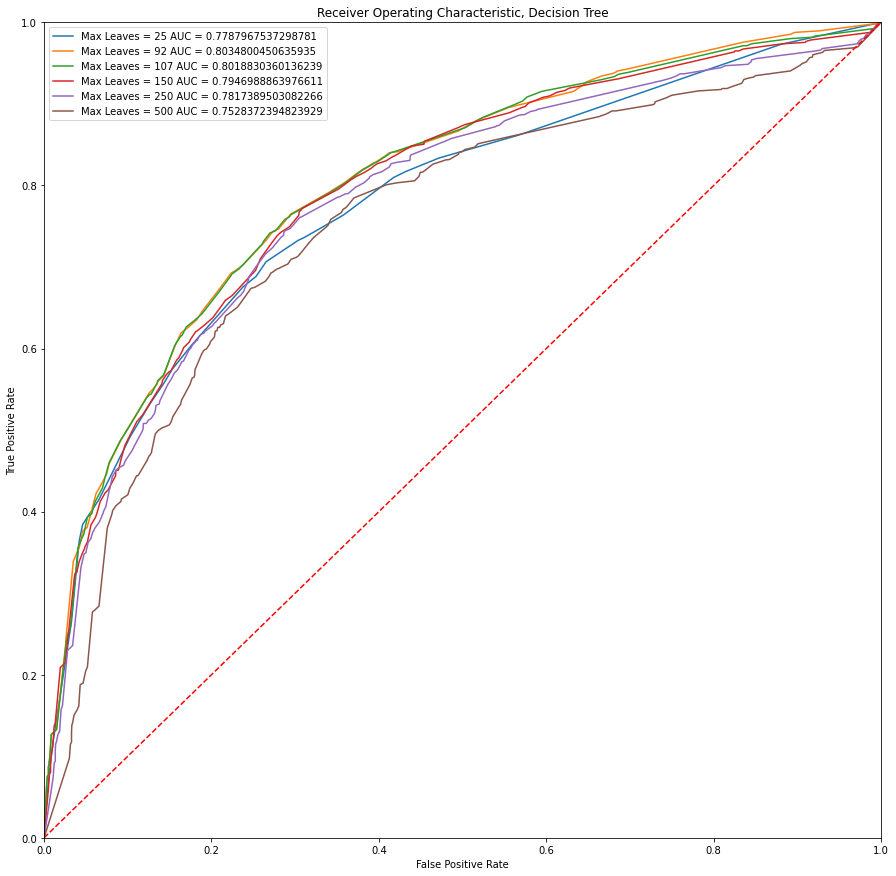

In [77]:
fig = plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic, Decision Tree')
for max_leaves in [25,92,107,150,250,500]:
    probs = get_probs_decision(max_leaves, OH_X_train, OH_X_valid, y_train, y_valid)
    fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'Max Leaves = {} AUC = {}'.format(max_leaves,roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC Decision Tree.png')
plt.show()

### KNN ahead

In [78]:
def get_accuracy_knn(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return accuracy_score(val_y, preds_val),f1_score(val_y, preds_val)

In [79]:
def get_probs_knn(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    probs = model.predict_proba(val_X)
    return probs

In [80]:
candidate_neighbors = list(range(2,200))

pbar = tqdm(total = len(candidate_neighbors))

accs = np.ones(len(candidate_neighbors)) * np.inf
f1s = np.ones(len(candidate_neighbors)) * np.inf

for idx, neighbors in enumerate(candidate_neighbors):
    accs[idx],f1s[idx] = get_accuracy_knn(neighbors, OH_X_train, OH_X_valid, y_train, y_valid)
    pbar.update(1)

best_n_neighbors = candidate_neighbors[int(np.argmax(accs))]

Text(0, 0.5, 'Accuracy')

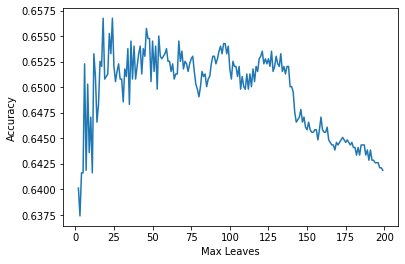

In [81]:
plt.plot(candidate_neighbors,accs)
plt.xlabel('Max Leaves')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1')

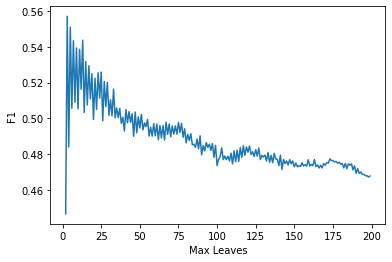

In [82]:
plt.plot(candidate_neighbors,f1s)
plt.xlabel('Max Leaves')
plt.ylabel('F1')

In [83]:
best_n_neighbors

18

In [84]:
candidate_neighbors[int(np.argmax(f1s))]

3

In [85]:
accs[candidate_neighbors[int(np.argmax(f1s))]]

0.6416170634920635

In [86]:
accs[candidate_neighbors[int(np.argmax(accs))]]

0.6510416666666666

In [87]:
get_accuracy_knn(18, OH_X_train, OH_X_valid, y_train, y_valid)

(0.6567460317460317, 0.5109540636042402)

In [88]:
model = KNeighborsClassifier(n_neighbors=18)
model.fit(OH_X_train, y_train)
preds_val = model.predict(OH_X_valid)
accuracy_score(y_valid, preds_val)

0.6567460317460317

In [89]:
probs = model.predict_proba(OH_X_valid)

In [90]:
probs

array([[0.22222222, 0.77777778],
       [0.94444444, 0.05555556],
       [0.72222222, 0.27777778],
       ...,
       [0.83333333, 0.16666667],
       [0.72222222, 0.27777778],
       [0.44444444, 0.55555556]])

In [91]:
preds

array([ True, False, False, ..., False, False, False])

In [92]:
fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic, KNN')
for neighbors in [3,5,7,9,13,18]:
    probs = get_probs_knn(neighbors, OH_X_train, OH_X_valid, y_train, y_valid)
    fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'Max Leaves = {} AUC = {}'.format(neighbors,roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC KNN.png')
plt.show()